 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [02/Oct/2023 15:49:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2023 15:49:45] "GET /docs/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2023 15:49:45] "GET /flasgger_static/swagger-ui-bundle.js HTTP/1.1" 304 -
127.0.0.1 - - [02/Oct/2023 15:49:45] "GET /flasgger_static/swagger-ui.css HTTP/1.1" 304 -
127.0.0.1 - - [02/Oct/2023 15:49:45] "GET /flasgger_static/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
127.0.0.1 - - [02/Oct/2023 15:49:45] "GET /flasgger_static/lib/jquery.min.js HTTP/1.1" 304 -
127.0.0.1 - - [02/Oct/2023 15:49:45] "GET /docs.json HTTP/1.1" 200 -
C:\Users\Dimas\AppData\Local\Temp\ipykernel_26220\3721859016.py:118: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if corrected_word:
D:\Dimas Data\Project Data Science\venv_test\myenv_2\Lib\site-packages\seaborn\_oldcor

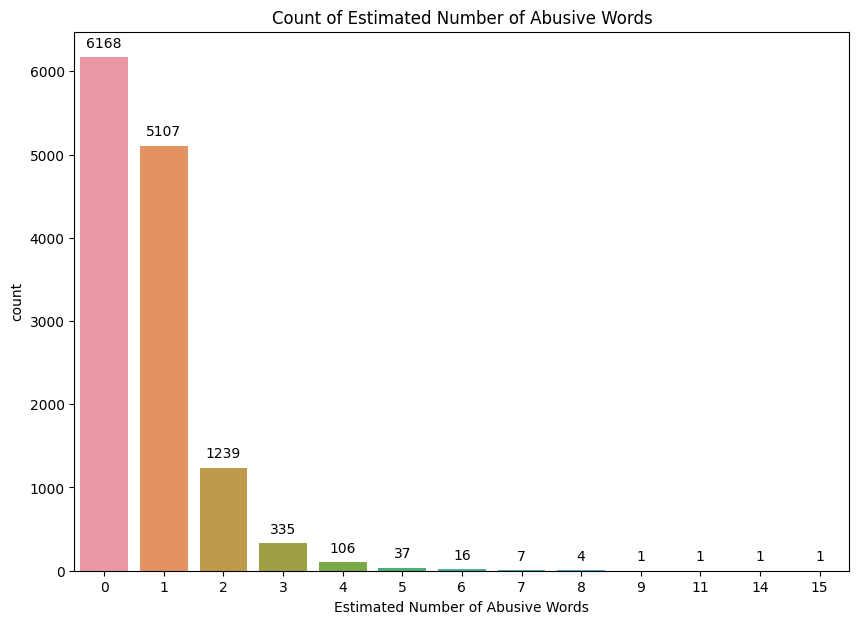

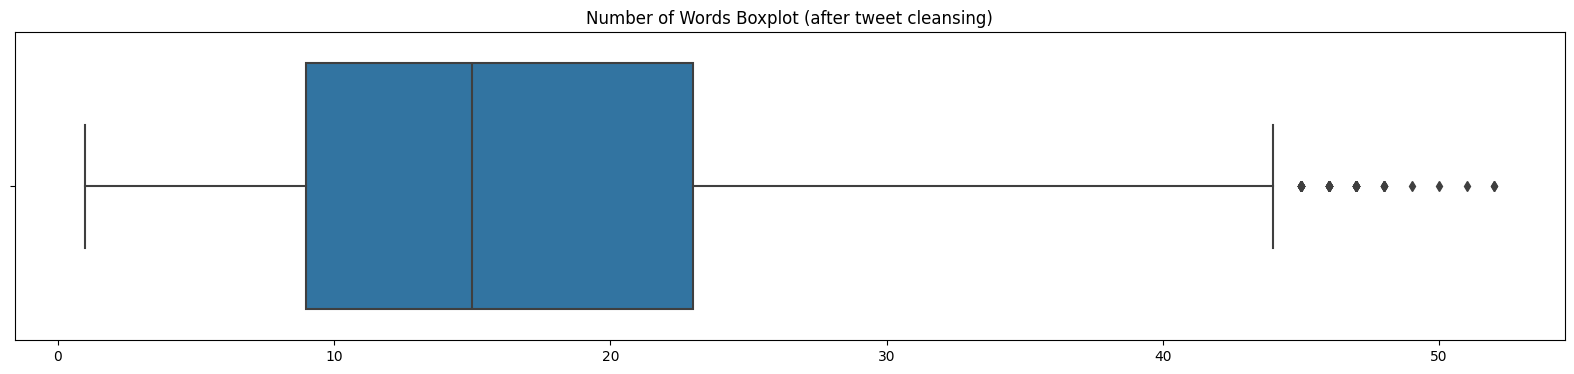

In [1]:
# IMPORT LIBRARIES FOR REGEX, PANDAS, NUMPY, SQLITE3, MATPLOTLIB, SEABORN, AND WARNINGS (TO IGNORE VISUALIZATION RESULT WARNING
import re
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# IMPORT LIBRARY FOR FLASK AND SWAGGER
from flask import Flask, jsonify, request
from flasgger import Swagger, LazyString, LazyJSONEncoder
from flasgger import swag_from

# DEFAULT FLASK AND SWAGGER DEFAULT SETTING
app = Flask(__name__)
app.json_encoder = LazyJSONEncoder
swagger_template = dict(
info = {
    'title': LazyString(lambda: 'API Documentation for Data Processing and Modeling'),
    'version': LazyString(lambda: '1.0.0'),
    'description': LazyString(lambda: 'Dokumentasi API untuk Data Processing dan Modeling'),
    },
    host = LazyString(lambda: request.host)
)
swagger_config = {
    "headers": [],
    "specs": [
        {
            "endpoint": 'docs',
            "route": '/docs.json',
        }
    ],
    "static_url_path": "/flasgger_static",
    "swagger_ui": True,
    "specs_route": "/docs/"
}
swagger = Swagger(app, template=swagger_template,             
                  config=swagger_config)

# IMPORT ABUSIVE.CSV AND NEW_KAMUSALAY.CSV TO PANDAS DATAFRAME (EACH)
df_abusive = pd.read_csv('C:/Users/Dimas/Binar-Challenge-Gold/abusive.csv')
df_kamusalay = pd.read_csv('C:/Users/Dimas/Binar-Challenge-Gold/new_kamusalay.csv', encoding='latin-1', header=None)
df_kamusalay.columns=["tidak baku","baku"]

# DEFINE ENDPOINTS: BASIC GET
@swag_from("C:/Users/Dimas/Binar-Challenge-Gold/hello_world.yml", methods=['GET'])
@app.route('/', methods=['GET'])
def hello_world():
    json_response = {
        'status_code': 200,
        'description': "Menyapa Hello World",
        'data': "Hello World",
    }
    response_data = jsonify(json_response)
    return response_data

# DEFINE ENDPOINTS: POST FOR TEXT PROCESSING FROM TEXT INPUT
@swag_from("C:/Users/Dimas/Binar-Challenge-Gold/text_processing.yml", methods=['POST'])
@app.route('/text-processing', methods=['POST'])
def text_processing():
    
    text = request.form.get('text')
    
    json_response = {
        'status_code': 200,
        'description': "Teks yang sudah diproses",
        'data': re.sub(r'[^a-zA-Z0-9]',' ', text)
    }
    
    response_data = jsonify(json_response)
    return response_data

# DEFINE ENDPOINTS: POST FOR TEXT PROCESSING FROM FILE
@swag_from("C:/Users/Dimas/Binar-Challenge-Gold/text_processing_file.yml", methods=['POST'])
@app.route('/text-processing-file', methods=['POST'])
def text_processing_file():
    global post_df, top_5_abusive_words
    
    # USING REQUEST TO GET FILE THAT HAS BEEN POSTED FROM API ENDPOINT
    file = request.files.get('file')
    
    # IMPORT FILE OBJECT INTO PANDAS DATAFRAME (YOU CAN SPECIFY NUMBER OF ROWS IMPORTED USING PARAMETER nrows=(integer value) )
    post_df = pd.read_csv(file, encoding='latin-1')
    
    # SET THE TWEET COLUMN ONLY FOR THE DATAFRAME
    post_df = post_df[['Tweet']]
    
    # DROP DUPLICATED TWEETS
    post_df.drop_duplicates(inplace=True)
    
    # CREATE NEW NUMBER OF CHARACTERS (NO_CHAR) COLUMN THAT CONSISTS OF LENGTH OF TWEET CHARACTERS
    post_df['no_char'] = post_df['Tweet'].apply(len)
    
    # CREATE NEW NUMBER OF WORDS (NO_WORDS) COLUMN THAT CONSISTS OF NUMBER OF WORDS OF EACH TWEET
    post_df['no_words'] = post_df['Tweet'].apply(lambda x: len(x.split()))
    
    # CREATE A FUNCTION TO CLEAN DATA FROM ANY NON ALPHA-NUMERIC (AND NON-SPACE) CHARACTERS, AND STRIP IT FROM LEADING/TRAILING SPACES
    def tweet_cleansing(x):
        tweet = x
        cleaned_tweet = re.sub(r'[^a-zA-Z0-9 ]','',tweet).strip()
        return cleaned_tweet
    
    # APPLY THE TWEET_CLEANSING FUNCTION ON TWEET COLUMN, AND CREATE A NEW CLEANED_TWEET COLUMN
    post_df['cleaned_tweet'] = post_df['Tweet'].apply(lambda x: tweet_cleansing(x))
    
    # CREATE NEW NO_CHAR, AND NO_WORDS COLUMNS BASED ON CLEANED_TWEET COLUMN
    post_df['no_char_2'] = post_df['cleaned_tweet'].apply(len)
    post_df['no_words_2'] = post_df['cleaned_tweet'].apply(lambda x: len(x.split()))
    
    # Function to correct typos in a cleaned tweet
    def fix_typos(cleaned_tweet):
        words = cleaned_tweet.split()
        corrected_words = []
        for word in words:
            # Check if the word is in the dictionary and replace it if a correction exists
            corrected_word = df_kamusalay[df_kamusalay["tidak baku"] == word]["baku"].values
            if corrected_word:
                corrected_words.append(corrected_word[0])
            else:
                corrected_words.append(word)
        return " ".join(corrected_words)

    # Apply the fix_typos function to the cleaned_tweet column
    post_df['cleaned_tweet'] = post_df['cleaned_tweet'].apply(fix_typos)
    
    # CREATE A FUNCTION TO COUNT NUMBER OF ABUSIVE WORDS FOUND IN A CLEANED TWEET
    def count_abusive(x):
        cleaned_tweet = x
        matched_list = []
        for i in range(len(df_abusive)):
            for j in x.split():
                word = df_abusive['ABUSIVE'].iloc[i]
                if word==j.lower():
                    matched_list.append(word)
        return len(matched_list)
    
    # APPLY THE FUNCTION TO COUNT ABUSIVE WORDS, AND CREATE A NEW COLUMN BASED OFF OF IT
    post_df['estimated_no_abs_words'] = post_df['cleaned_tweet'].apply(lambda x: count_abusive(x))
    
    # Create a function to extract abusive words from a cleaned tweet
    def extract_abusive_words(x):
        cleaned_tweet = x
        abusive_words = []
        for word in cleaned_tweet.split():
            if word.lower() in df_abusive['ABUSIVE'].str.lower().values:
                abusive_words.append(word.lower())
        return abusive_words
    
    # Apply the function to extract abusive words from each cleaned tweet
    post_df['abusive_words'] = post_df['cleaned_tweet'].apply(lambda x: extract_abusive_words(x))
    
    # Flatten the list of abusive words
    all_abusive_words = [word for words_list in post_df['abusive_words'] for word in words_list]

    # Count the frequency of each abusive word
    abusive_word_counts = pd.Series(all_abusive_words).value_counts()

    # Get the top 5 most abusive words
    top_5_abusive_words = abusive_word_counts.head(5)
    
    
    # CONNECT / CREATE NEW DATABASE AND CREATE NEW TABLE CONSISTING LISTED TABLES
    conn = sqlite3.connect('database_project.db')
    q_create_table = """
    create table if not exists post_df (Tweet varchar(255), no_char int, no_words int, cleaned_tweet varchar(255), no_char_2 int, no_words_2 int);
    """
    conn.execute(q_create_table)
    conn.commit()
    
    # CHECK WHETHER TABLE ALREADY HAS DATA IN IT (TABLE HAS ROWS OF DATA IN IT)
    cursor = conn.execute("select count(*) from post_df")
    num_rows = cursor.fetchall()
    num_rows = num_rows[0][0]
    
    #  DO DATA INSERTIONS IF TABLE HAS NO DATA IN IT    
    if num_rows == 0:
    # DO ITERATIONS TO INSERT DATA (EACH ROW) FROM FINAL DATAFRAME (POST_DF)
        for i in range(len(post_df)):
            tweet = post_df['Tweet'].iloc[i]
            no_char = int(post_df['no_char'].iloc[i])
            no_words = int(post_df['no_words'].iloc[i])
            cleaned_tweet = post_df['cleaned_tweet'].iloc[i]
            no_char_2 = int(post_df['no_char_2'].iloc[i])
            no_words_2 = int(post_df['no_words_2'].iloc[i])
    
            q_insertion = "insert into post_df (Tweet, no_char, no_words, cleaned_tweet, no_char_2, no_words_2) values (?,?,?,?,?,?)"
            conn.execute(q_insertion,(tweet,no_char,no_words,cleaned_tweet,no_char_2,no_words_2))
            conn.commit()    
    
    conn.close()
    
    
    # VISUALIZE THE NUMBER OF ABUSIVE WORDS USING BARPLOT (COUNTPLOT)
    plt.figure(figsize=(10,7))
    countplot = sns.countplot(data=post_df, x="estimated_no_abs_words")
    for p in countplot.patches:
        countplot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center'
                            , va = 'center', xytext = (0, 10), textcoords = 'offset points')

    # %matplotlib inline
    # warnings.filterwarnings('ignore', category=FutureWarning)

    plt.title('Count of Estimated Number of Abusive Words')
    plt.xlabel('Estimated Number of Abusive Words')
    plt.savefig('new_countplot.jpeg')
    
    plt.figure(figsize=(20,4))
    boxplot = sns.boxplot(data=post_df, x="no_words_2")

    print()
    
    # VISUALIZE THE NUMBER OF WORDS USING BOXPLOT
    # %matplotlib inline
    # warnings.filterwarnings('ignore', category=FutureWarning)

    plt.title('Number of Words Boxplot (after tweet cleansing)')
    plt.xlabel('')
    plt.savefig('new_boxplot.jpeg')
    
    # OUTPUT THE RESULT IN JSON FORMAT
    json_response = {
        'status_code': 200,
        'description': "Teks yang sudah diproses",
        'data': list(post_df['cleaned_tweet'])
    }
    
    response_data = jsonify(json_response)
    return response_data

if __name__ == "__main__":
    app.run()

In [2]:
top_5_abusive_words

asing      554
cebong     492
komunis    410
rezim      353
kafir      335
Name: count, dtype: int64

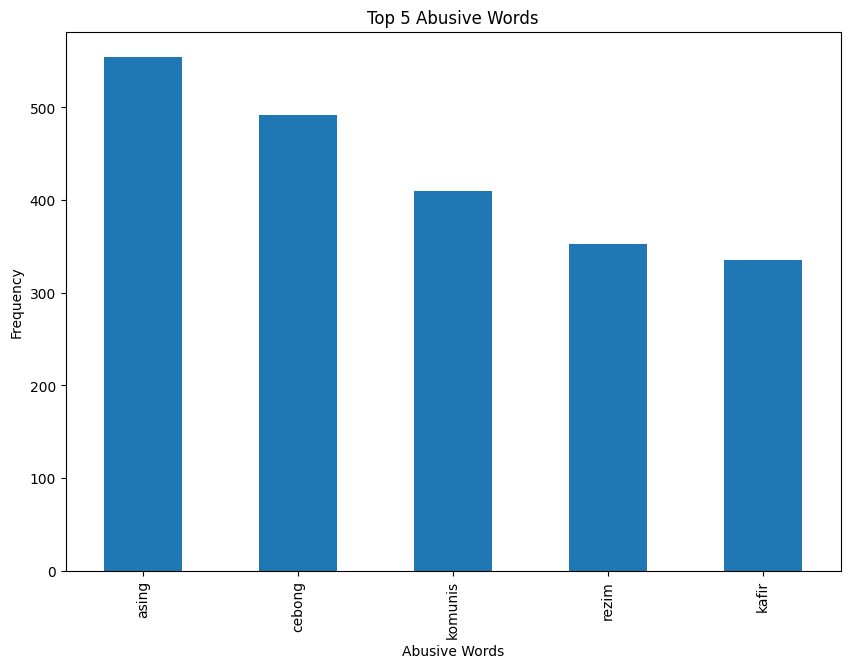

In [3]:
# Create a bar plot for the top 5 abusive words
plt.figure(figsize=(10, 7))
top_5_abusive_words.plot(kind='bar')
plt.title('Top 5 Abusive Words')
plt.xlabel('Abusive Words')
plt.ylabel('Frequency')
plt.savefig('top_5_abusive_words.png')

In [4]:
post_df

,Tweet,no_char,no_words,cleaned_tweet,no_char_2,no_words_2,estimated_no_abs_words,abusive_words
0,- disaat semua cowok berusaha melacak perhatia...,138,25,di saat semua cowok berusaha melacak perhatian...,127,21,1,[bego]
1,RT USER: USER siapa yang telat ngasih tau elu?...,120,21,RT USER USER siapa yang telat memberi tau elue...,117,21,1,[sarap]
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",254,37,41 Kadang aku berpikir kenapa aku tetap percay...,247,37,0,[]
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,75,14,USER USER AKU ITU AKUnnKU TAU MATAMU SIPIT TAP...,72,14,1,[sipit]
4,USER USER Kaum cebong kapir udah keliatan dong...,89,14,USER USER Kaum cebong kafir sudah kelihatan do...,88,14,3,"[cebong, kafir, dungu]"
...,...,...,...,...,...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,61,10,USER jangan asal berbicara ndasmu congor kamu ...,59,10,2,"[congor, anjing]"
13165,USER Kasur mana enak kunyuk',28,5,USER Kasur mana enak kunyuk,27,5,1,[kunyuk]
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,62,9,USER Hati hati bisu gnnlagi bosan duh xf0x9fx9...,52,8,1,[bisu]
13167,USER USER USER USER Bom yang real mudah terdet...,135,22,USER USER USER USER Bom yang real mudah terdet...,134,22,0,[]


In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
